### IBM Data Science Professional Certificate - Capstone Project
This notebook develops the work of the IBM Data Science Professional Certificate Capstone Project on Coursera.

Author: Josep Rotger

# **Leveraging nearby places and businesses' public data as predictors of housing prices: The case of Barcelona neighborhoods with the use of Foursquare Places API.**

### **Table Of Contents:**

1. [Abstract](#id_Abstract)
2. [Introduction](#id_Introduction)
3. [Data acquisition and cleaning](#id_Data)
4. [Methodology](#id_Methodology)
5. [Results and discussion](#id_Results-Discussion)
6. [Conclusion](#id_Conclusion)
7. [References](#id_References)

<a id="id_Abstract"></a>
### **1. Abstract**

It is not uncommon practice for data savvy individuals to leverage publicly available data to help in their quest to buy a home. In fact, even the Spanish Government promotes the use of data analytics tools and services to help in that regard [1,2], since being knowledgeable about data makes for smarter citizens.

On the other hand, in the business domain, and as such in the Real Estate industry, data is old news. But Information Technology is a fast developing field and advancement and innovation needs to be made in order to stay competitive. This drive is what propels companies such as Real Estate investment platform Cadre, who in the beginning of 2020 became the first Real Estate investment firm to license Foursquare location data to power their investment seeking end evaluation machinery [3].

<a id="id_Introduction"></a>
### **2. Introduction**

The aim of this project is to provide evidence that leveraging places and businesses' public data available on social media platforms such as Foursquare can enhance prediction performance of traditional valuation models. The objective is not to provide a comprehensive housing price estimator, but rather show at neighborhood scale how the presence of a **set of places and businesses describe the neighborhoods' variation in its second-hand housing price per square meter (€/m2).**

This work sets out to analyze Barcelona's neighborhoods in order to glean insights through the leveraging of precise location data provided by social media platforms, with the intent of proving its usefulness in improving accuracy when used in combination with traditional housing price estimation models.

Foursquare's venue category data, available in the free version of its Places API, will be used for this model. Nevertheless, other data available in its pay-per-use version, such as venue price range or __ could be used to possibly improve prediction accuracy. Other APIs such as Facebook Graph API, Yelp Fusion API or Google Places API could also be used to provide useful data to feed a price estimation model.

For this purpose, data will be retrieved, aggregated by neighborhood, from the Barcelona City Council statistics publications. Each neighborhood's average price per square meter (€/m2) will be joined with the venue categories in each neighborhood, and a model will be developed to see if certain types of venues present in a neighborhood can prove good predictors of its price per square meter.

<a id="id_Data"></a>
### **3. Data acquisition and cleaning**

Since Covid-19 shook many markets, although the Real Estate market not being as badly affected as others, pricing data from year 2020 is taken with caution, and an estimation will be performed for 2019 as well as 2020.

Official data was retrieved by scraping the statistics publications page of Barcelona City Council, which reflect the yearly average price aggregated by neighborhood, for all 72 neighborhoods in Barcelona.

Data from social media platform Foursquare was retrieved through its Places API with a free account as of February 2021. The data used was restricted to that available with free access, but other meaningful data such as popular hours, price range, rating and more, available in pay-per-use versions of the API, could be used in further studies to improve prediction accuracy of the model.

It must be noted that the estimation of prices for 2019 pricing data will be performed with current venue details retrieved as of February 2021, since historical data for 2019 could not be retrieved from the Foursquare API.

Datasets:

* Barcelona City Council statistics publications datasets:
  * [**Asking price of second-hand housing - Year 2019**](https://www.bcn.cat/estadistica/angles/dades/timm/ipreus/hab2mave/a2019/t2019b.htm):
    * District
    * Neighborhood
    * Asking price (€/m2)
  * [**Asking price of second-hand housing - Year 2020**](https://www.bcn.cat/estadistica/angles/dades/timm/ipreus/hab2mave/a2020/t2020b.htm):
    * District
    * Neighborhood
    * Asking price (€/m2)

* Foursquare Places API:
  * **Venue Category data**:
    * Venues within a specified radius from the center of the neighborhood
    * Category of the venue (such as Tapas Restaurant, Cocktail Bar, Supermarket, Park, Plaza, Metro Station, Wine Shop, etc).

#### **3.1 Library imports**

In [ ]:
#Library imports

import requests
#import json
import numpy as np
import pandas as pd
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

#!conda install -c anaconda urllib3
import urllib3

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


In [ ]:
#Use of colab-env library to load the Foursquare API credentials
!pip install colab-env -qU
import colab_env
import os
foursquare_client_id = os.getenv("FOURSQUARE_CLIENT_ID")
foursquare_client_secret = os.getenv("FOURSQUARE_CLIENT_SECRET")

Mounted at /content/gdrive


#### **3.1 Data Extraction and Cleaning**

In [ ]:
#Web scraping Barcelona City Council statistics publications with Pandas
url_2019 = 'https://www.bcn.cat/estadistica/angles/dades/timm/ipreus/hab2mave/a2019/t2019b.htm'
url_2020 = 'https://www.bcn.cat/estadistica/angles/dades/timm/ipreus/hab2mave/a2020/t2020b.htm'
data_2019 = pd.read_html(url_2019, header = 0, thousands='.', decimal=',')
data_2020 = pd.read_html(url_2020, header = 0, thousands='.', decimal=',')

In [ ]:
#Cleaning and preparation of a Pandas DataFrame

#Creating a 2020 dataframe
df_neighborhoods_2020 = data_2020[0]
df_neighborhoods_2020 = df_neighborhoods_2020.iloc[8:-12,3:]
df_neighborhoods_2020.reset_index(drop=True, inplace=True)
df_neighborhoods_2020.columns = ["Neighborhood", "Average_price_2020"]

df_neighborhoods_2020[["District", "Neighborhood"]] = df_neighborhoods_2020.Neighborhood.str.split(n=1, expand=True)
df_neighborhoods_2020["Neighborhood"] = df_neighborhoods_2020["Neighborhood"].str.lstrip('0123456789. ')
df_neighborhoods_2020["Neighborhood"] = df_neighborhoods_2020["Neighborhood"].str.rstrip('()0123456789. ')
fixed_columns_list = [df_neighborhoods_2020.columns[-1]] + list(df_neighborhoods_2020.columns[:-1])
df_neighborhoods_2020 = df_neighborhoods_2020[fixed_columns_list]

print("df_neighborhoods_2020 shape is {}".format(df_neighborhoods_2020.shape))

#Creating a 2019 dataframe
df_neighborhoods_2019 = data_2019[0]
df_neighborhoods_2019 = df_neighborhoods_2019.iloc[8:-10,3:]
df_neighborhoods_2019.reset_index(drop=True, inplace=True)
df_neighborhoods_2019.columns = ["Neighborhood", "Average_price_2019"]

df_neighborhoods_2019[["District", "Neighborhood"]] = df_neighborhoods_2019.Neighborhood.str.split(n=1, expand=True)
df_neighborhoods_2019["Neighborhood"] = df_neighborhoods_2019["Neighborhood"].str.lstrip('0123456789. ')
df_neighborhoods_2019["Neighborhood"] = df_neighborhoods_2019["Neighborhood"].str.rstrip('()0123456789. ')
fixed_columns_list = [df_neighborhoods_2019.columns[-1]] + list(df_neighborhoods_2019.columns[:-1])
df_neighborhoods_2019 = df_neighborhoods_2019[fixed_columns_list]

print("df_neighborhoods_2019 shape is {}".format(df_neighborhoods_2019.shape))

#Merging both dataframes
df_neighborhoods = df_neighborhoods_2020.merge(df_neighborhoods_2019[["Neighborhood", "Average_price_2019"]], left_on="Neighborhood", right_on="Neighborhood", how="outer")

#As indicated in the Barcelona statistics page, we will treat the n.d. and NaN values in the following ways:
#Drop rows with n.d. in the Average price columns
df_neighborhoods.drop(df_neighborhoods[df_neighborhoods["Average_price_2020"] == "n.d."].index, inplace=True)
df_neighborhoods.drop(df_neighborhoods[df_neighborhoods["Average_price_2019"] == "n.d."].index, inplace=True)
#Here is applicable the forward-filling method for NaN values
df_neighborhoods["Average_price_2020"] = df_neighborhoods["Average_price_2020"].fillna(method='ffill')
df_neighborhoods["Average_price_2019"] = df_neighborhoods["Average_price_2019"].fillna(method='ffill')
#We change the data type of Average price columns to float
df_neighborhoods["Average_price_2020"] = df_neighborhoods["Average_price_2020"].astype(float)
df_neighborhoods["Average_price_2019"] = df_neighborhoods["Average_price_2019"].astype(float)
#Finally, we reset the indexes
df_neighborhoods.reset_index(drop=True, inplace=True)

#Addressing future problems with geocoding in the following steps:
#We will address three names that otherwise will not be recognised by the geolocator
df_neighborhoods.replace(["el Poble Sec-AEI Parc Montjuïc", "la Marina del Prat Vermell-AEI Zona Franca", "Sant Andreu"],
                         ["el Poble Sec", "la Marina del Prat Vermell", "Sant Andreu de Palomar"], inplace=True)
#We will rename the District column with the actual names of the districts
df_neighborhoods["District"].replace(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
                                     ["Ciutat Vella", "Eixample", "Sants-Montjuïc", "Les Corts",
                                      "Sarrià-Sant Gervasi", "Gràcia", "Horta-Guinardó", "Nou Barris",
                                      "Sant Andreu", "Sant Martí"], inplace=True)

print("df_neighborhoods shape after cleaning is {}".format(df_neighborhoods.shape))
df_neighborhoods.head()

df_neighborhoods_2020 shape is (73, 3)
df_neighborhoods_2019 shape is (73, 3)
df_neighborhoods shape after cleaning is (69, 4)


,District,Neighborhood,Average_price_2020,Average_price_2019
0,Ciutat Vella,el Raval,3587.0,4591.0
1,Ciutat Vella,el Barri Gòtic,4717.0,3811.0
2,Ciutat Vella,la Barceloneta,4763.0,4849.0
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",4837.0,4772.0
4,Eixample,el Fort Pienc,4091.0,4250.0


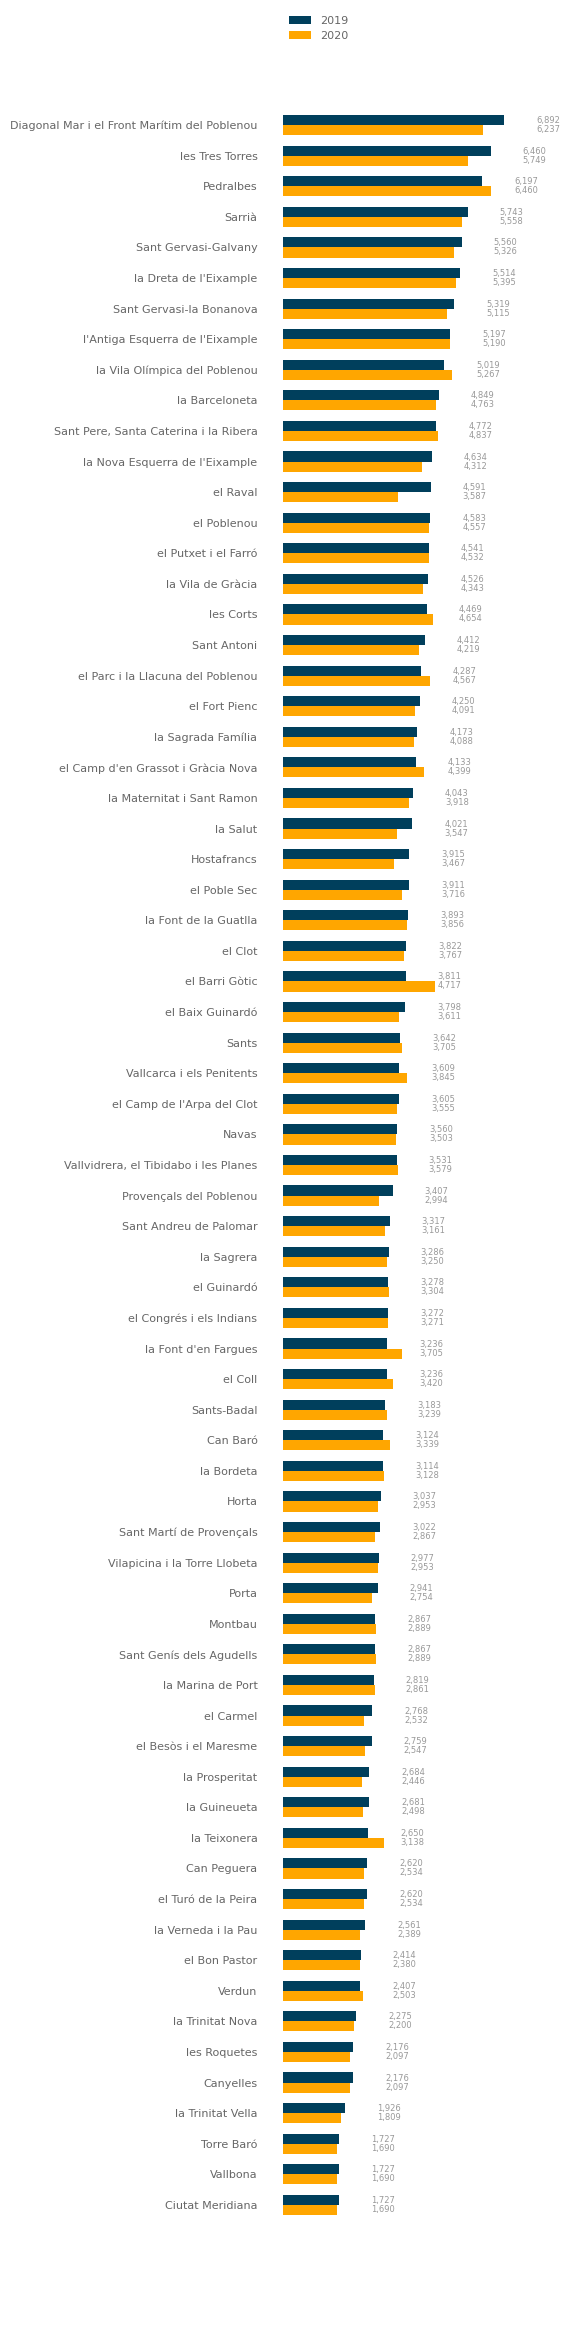

In [ ]:
#Bar chart of neighborhood prices per square meter for 2019 and 2020

plt.rcdefaults()

#Data
df_neighborhoods_sorted = df_neighborhoods.sort_values(by=['Average_price_2019'], ascending=False)
y_labels = list(df_neighborhoods_sorted["Neighborhood"])
y_pos = np.arange(len(y_labels))
x_price_2019 = list(df_neighborhoods_sorted["Average_price_2019"])
x_price_2020 = list(df_neighborhoods_sorted["Average_price_2020"])

fig, ax = plt.subplots(figsize=(3,30))
width = 0.33
rects1 = ax.barh(y_pos - width/2, x_price_2019, width, label='Average_price_2019', color="#003f5c", align='center')
rects2 = ax.barh(y_pos + width/2, x_price_2020, width, label='Average_price_2020', color="#ffa600", align='center')

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 15))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_yticks(y_pos)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_yticklabels(y_labels, color='#666666', size=8)
ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xlabel('Price', size=12)
#ax.set_title('Average price per square meter in Barcelona', size=14, color='#666666')
ax.get_xaxis().set_visible(False)

#Legend formatting
l = ax.legend(['2019', '2020'], loc='upper left',frameon=False, borderpad=0, fontsize=8)
for text in l.get_texts():
    text.set_color("#666666")

#Labeling each bar with its value
for i, (v1, v2) in enumerate(zip(x_price_2019, x_price_2020)):
  v1 = int(v1)
  ax.text(v1 + 1000, i, str(format(v1, ",")), color='#999999', fontweight='regular', fontsize=6, ha='left', va='bottom')
  v2 = int(v2)
  ax.text(v1 + 1000, i, str(format(v2, ",")), color='#999999', fontweight='regular', fontsize=6, ha='left', va='top')

plt.show()

#### **3.2 Adding geolocation data to neighborhods**

Now we use the geopy library to get the latitude and longitude values of the neighborhoods of Barcelona.

The process consists in retrieving the centers of the neighborhoods, which will then be used to make calls to the 'venues/explore' endpoint of the Foursquare API, defining a radius to search venues within a specific distance of the neighborhood center.

This approach is a simplification to that which would consist in finding every venue within each neighborhood's boundaries, which is chosen so as to conform to the available features of the Foursquare API free access version.

In [ ]:
import geopy
geolocator = Nominatim(user_agent="bcn_explorer")
df_neighborhoods["Latitude"] = np.nan
df_neighborhoods["Longitude"] = np.nan
for i, (district, neighborhood) in enumerate(zip(df_neighborhoods.loc[:,"District"], df_neighborhoods.loc[:, "Neighborhood"])):
  addr = geolocator.geocode('{}, {}, Barcelona, Barcelona, Spain'.format(neighborhood, district), timeout=10)
  print('{}, {}, Barcelona, Barcelona, Spain'.format(neighborhood, district))
  if addr:
    latitude = addr.latitude
    longitude = addr.longitude
    df_neighborhoods.loc[i, "Latitude"] = latitude
    df_neighborhoods.loc[i, "Longitude"] = longitude
  else:
    continue
    
df_neighborhoods.head()

el Raval, Ciutat Vella, Barcelona, Barcelona, Spain
el Barri Gòtic, Ciutat Vella, Barcelona, Barcelona, Spain
la Barceloneta, Ciutat Vella, Barcelona, Barcelona, Spain
Sant Pere, Santa Caterina i la Ribera, Ciutat Vella, Barcelona, Barcelona, Spain
el Fort Pienc, Eixample, Barcelona, Barcelona, Spain
la Sagrada Família, Eixample, Barcelona, Barcelona, Spain
la Dreta de l'Eixample, Eixample, Barcelona, Barcelona, Spain
l'Antiga Esquerra de l'Eixample, Eixample, Barcelona, Barcelona, Spain
la Nova Esquerra de l'Eixample, Eixample, Barcelona, Barcelona, Spain
Sant Antoni, Eixample, Barcelona, Barcelona, Spain
el Poble Sec, Sants-Montjuïc, Barcelona, Barcelona, Spain
la Marina de Port, Sants-Montjuïc, Barcelona, Barcelona, Spain
la Font de la Guatlla, Sants-Montjuïc, Barcelona, Barcelona, Spain
Hostafrancs, Sants-Montjuïc, Barcelona, Barcelona, Spain
la Bordeta, Sants-Montjuïc, Barcelona, Barcelona, Spain
Sants-Badal, Sants-Montjuïc, Barcelona, Barcelona, Spain
Sants, Sants-Montjuïc, Barce

,District,Neighborhood,Average_price_2020,Average_price_2019,Latitude,Longitude
0,Ciutat Vella,el Raval,3587.0,4591.0,41.379518,2.168368
1,Ciutat Vella,el Barri Gòtic,4717.0,3811.0,41.383395,2.176912
2,Ciutat Vella,la Barceloneta,4763.0,4849.0,41.380653,2.189927
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",4837.0,4772.0,41.388322,2.177411
4,Eixample,el Fort Pienc,4091.0,4250.0,41.395925,2.182325


In [ ]:
#Now we create a map of Barcelona with the neighborhoods superimposed on top
import folium
map_barcelona = folium.Map(location=[41.403178, 2.157166], zoom_start=12, tiles="OpenStreetMap")

#add markers to map
for lat, lng, neighborhood in zip(df_neighborhoods['Latitude'],
                                  df_neighborhoods['Longitude'],
                                  df_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#333333',
        fill_opacity=1,
        parse_html=False).add_to(map_barcelona)  
    
map_barcelona

#### **3.3 Retrieval and transformation of venue categories from Foursquare API**

The top 50 venues and their categories within a radius of 500 of each neighborhood center will be retrieved.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(
            foursquare_client_id, 
            foursquare_client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#Before we call the function, we define some parameters to make the API call URLs:
version = '20180604' #This is the version of the API which we will use to run the API calls
limit = 50 #50 is the maximum results that the API can return for the 'venues/explore' endpoint we are using
r = 500 #We choose a reasonable radius from the center of the neighborhood to retrieve the neighborhood's venues

bcn_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                             latitudes=df_neighborhoods['Latitude'],
                             longitudes=df_neighborhoods['Longitude'],
                             radius=r)

el Raval
el Barri Gòtic
la Barceloneta
Sant Pere, Santa Caterina i la Ribera
el Fort Pienc
la Sagrada Família
la Dreta de l'Eixample
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
Sant Antoni
el Poble Sec
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants-Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, el Tibidabo i les Planes
Sarrià
les Tres Torres
Sant Gervasi-la Bonanova
Sant Gervasi-Galvany
el Putxet i el Farró
Vallcarca i els Penitents
el Coll
la Salut
la Vila de Gràcia
el Camp d'en Grassot i Gràcia Nova
el Baix Guinardó
Can Baró
el Guinardó
la Font d'en Fargues
el Carmel
la Teixonera
Sant Genís dels Agudells
Montbau
Horta
Vilapicina i la Torre Llobeta
Porta
el Turó de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baró
Ciutat Meridiana
Vallbona
la Trinitat Vella
el Bon Pastor
Sant Andreu de Palomar
la Sagrera
el Congrés i els Indians
Navas
el Camp de l'Arpa del Clot
el

In [ ]:
#Now we check the size and head of the resulting dataframe
print(bcn_venues.shape)
bcn_venues.head()

(2307, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,el Raval,41.379518,2.168368,A Tu Bola,41.380096,2.169054,Tapas Restaurant
1,el Raval,41.379518,2.168368,La Robadora,41.379500,2.170463,Gastropub
2,el Raval,41.379518,2.168368,Arume,41.378953,2.166008,Spanish Restaurant
3,el Raval,41.379518,2.168368,Chulapio,41.379264,2.165905,Cocktail Bar
4,el Raval,41.379518,2.168368,Cera 23,41.378947,2.166180,Spanish Restaurant


In [ ]:
#Display some descriptive statistics on the categorical columns
bcn_venues.describe(include='object')

,Neighborhood,Venue,Venue Category
count,2307,2307,2307
unique,69,1874,252
top,la Font de la Guatlla,Caprabo,Spanish Restaurant
freq,50,25,126


In [ ]:
#We can check te list of unique Venue Categories we retrieved
print("There are a total of {} unique venue categories. \
\n\n Each category count is as follows: \n\n {} ".format(
    len(bcn_venues['Venue Category'].unique()),
    bcn_venues["Venue Category"].value_counts())
)

There are a total of 252 unique venue categories. 

 Each category count is as follows: 

 Spanish Restaurant                 126
Tapas Restaurant                   120
Café                                91
Restaurant                          88
Mediterranean Restaurant            86
Bakery                              83
Hotel                               73
Pizza Place                         71
Grocery Store                       69
Supermarket                         67
Plaza                               65
Bar                                 61
Park                                49
Italian Restaurant                  47
Burger Joint                        44
Coffee Shop                         40
Japanese Restaurant                 35
Cocktail Bar                        33
Breakfast Spot                      30
Asian Restaurant                    26
Sandwich Place                      23
Hostel                              23
Gym / Fitness Center                23
Gym         

In [ ]:
#We will remove some categories with little representation to prevent introducing noise to the model
#We will reduce the list to those that have a count higher than 3
bcn_venues = (bcn_venues[bcn_venues.groupby("Venue Category")["Venue Category"].transform('size') > 5])
print("We end up with {} unique categories.\n\n".format(len(bcn_venues['Venue Category'].unique())))
bcn_venues["Venue Category"].describe()

We end up with 76 unique categories.




count                   1939
unique                    76
top       Spanish Restaurant
freq                     126
Name: Venue Category, dtype: object

In [ ]:
#Before fitting our data into a model, we need to perform some feature engineering
#In this case, we will perform one-hot encoding of the categorical variable "Venue Category"
bcn_venues_temp = bcn_venues['Venue Category']
bcn_onehot = pd.get_dummies(bcn_venues_temp)
print(bcn_onehot.shape)
bcn_onehot.head()

(1939, 76)


,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Museum,Nightclub,Paella Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Snack Place,Soccer Field,South American Restaurant,Spanish Restaurant,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#We add neighborhood column back to dataframe, since we will use it to proceed with feature engineering
bcn_onehot.insert(0, 'Neighborhoods', bcn_venues['Neighborhood'], allow_duplicates=False)
#Now we group the rows by neighborhood and take the mean of the frequency of occurrence of each category
bcn_grouped = bcn_onehot.groupby('Neighborhoods').mean().reset_index()
print(bcn_grouped.shape)
bcn_grouped.head()

(69, 77)


,Neighborhoods,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Museum,Nightclub,Paella Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Snack Place,Soccer Field,South American Restaurant,Spanish Restaurant,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Can Baró,0.0,0.0,0.0,0.041667,0.041667,0.0,0.000000,0.041667,0.0,0.041667,0.0,0.0,0.041667,0.083333,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.000000,0.041667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.041667,0.041667,0.0,0.083333,0.0,0.0,0.041667,0.0,0.166667,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.000,0.0,0.0,0.0,0.0
1,Can Peguera,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.083333,0.0,0.083333,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.083333,0.0,0.083333,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2,Canyelles,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1,0.100000,0.100,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.000000,0.0,0.0,0.200000,0.0,0.000000,0.000000,0.000000,0.0,0.100000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
3,Ciutat Meridiana,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.125000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.375,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.125000,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.0
4,Diagonal Mar i el Front Marítim del Poblenou,0.0,0.0,0.0,0.043478,0.000000,0.0,0.043478,0.000000,0.0,0.043478,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.000000,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.086957,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.217391,0.000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.217391,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0


#### **3.4 Display top 10 venues for each neighborhood**

In [ ]:
#Function to sort the venues in descending order:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bcn_grouped['Neighborhoods']

for ind in np.arange(bcn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bcn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Can Baró,Spanish Restaurant,Chinese Restaurant,Grocery Store,Tapas Restaurant,Scenic Lookout,Historic Site,Breakfast Spot,Park,Plaza,Restaurant
1,Can Peguera,Park,Hostel,Tapas Restaurant,Escape Room,Café,Sports Club,Supermarket,Food & Drink Shop,Grocery Store,Gym / Fitness Center
2,Canyelles,Soccer Field,Mediterranean Restaurant,Plaza,Grocery Store,Tapas Restaurant,Food & Drink Shop,Market,Café,Metro Station,Food
3,Ciutat Meridiana,Metro Station,Plaza,Park,Train Station,Grocery Store,Supermarket,Wine Shop,Diner,Escape Room,Falafel Restaurant
4,Diagonal Mar i el Front Marítim del Poblenou,Restaurant,Mediterranean Restaurant,Hotel,Italian Restaurant,Breakfast Spot,Pizza Place,Plaza,Fast Food Restaurant,Café,Park
5,Horta,Tapas Restaurant,Spanish Restaurant,Bakery,Pizza Place,Restaurant,Sandwich Place,Mediterranean Restaurant,Pedestrian Plaza,Snack Place,Chinese Restaurant
6,Hostafrancs,Tapas Restaurant,Spanish Restaurant,Hotel,Mediterranean Restaurant,Bakery,Pizza Place,Wine Bar,Asian Restaurant,Bar,Breakfast Spot
7,Montbau,Park,Plaza,Argentinian Restaurant,Spanish Restaurant,Gym,Diner,Restaurant,Chinese Restaurant,Soccer Field,Breakfast Spot
8,Navas,Supermarket,Grocery Store,Bakery,Tapas Restaurant,Plaza,Spanish Restaurant,Restaurant,Asian Restaurant,Coffee Shop,Italian Restaurant
9,Pedralbes,Spanish Restaurant,Mediterranean Restaurant,Pizza Place,Hotel,Nightclub,Park,Plaza,Restaurant,Café,Hot Dog Joint


### **4. Methodology**

The methodology of this project consists in using regression methods to predict the second-hand housing list price per square meter (€/m2) at neighborhood scale. Price data from 2019 and 2020 will be used in order to see whether Covid-19 could have a significant impact on the model.

**First step:**

The target variables for 2019 and 2020 prices will be added to the dataset, and train/test splitting will be performed before the following steps.

**Second step:**

Since the dataset has high dimensionality, with more dimensions (p=78) than observations (n=69), often represented as **p>>n**, some dimensionality reduction procedure is advisable. Since it is interesting for the purpose of this work to keep the model explainable, **feature selection** will be performed, rather than feature projection/extraction. A **correlation matrix** will be used to filter out less relevant features. It must be reminded that features (venue categories) with frequency count equal or lower than 5 have already been removed from the dataset.

A note on feature selection with the correlation matrix:
Since one-hot encoding was used, multicollinearity and sparsity of predictor variables is often present. The  degree of multicollinearity greatly impacts the p-values and coefficients, but not prediction accuracy of the model. Since the goal is to produce a model that is able to perform predictions, not necessarily retrieve the significance of the predictor variables, fixing multicollinarity will not be deemed applicable.

**Third step:**

The dataset will be used, after feature seleciton, to fit a **Multiple Linear Regression** model, the use of which is often appropriate for small datasets such as the one this study is dealing with. For the sake of comparison, a **Random Forest Regressor** will also be fit. Although, since Random Forests are highly data adaptive and can take large numbers of predictors with fewer observations (p>n), the dataset before feature selection will be used.

As formerly stated, both price target variables for 2019 and 2020 will be predicted for both models.

#### **4.1 Addition of the target variables to the dataset and train/test splitting**

In [ ]:
#Finally we add each neighborhood's average prices of 2019 and 2020 to the dataset we one-hot encoded and transformed by grouping.
bcn_grouped = bcn_grouped.merge(df_neighborhoods[['Neighborhood','Average_price_2019', 'Average_price_2020']], left_on='Neighborhoods', right_on='Neighborhood')
#We remove the duplicated column 'Neighborhood
bcn_grouped = bcn_grouped.drop('Neighborhood', axis=1)
bcn_grouped.head()

,Neighborhoods,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Museum,Nightclub,Paella Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Snack Place,Soccer Field,South American Restaurant,Spanish Restaurant,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Average_price_2019,Average_price_2020
0,Can Baró,0.0,0.0,0.0,0.041667,0.041667,0.0,0.000000,0.041667,0.0,0.041667,0.0,0.0,0.041667,0.083333,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.000000,0.041667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.041667,0.041667,0.0,0.083333,0.0,0.0,0.041667,0.0,0.166667,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.000,0.0,0.0,0.0,0.0,3124.0,3339.0
1,Can Peguera,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.083333,0.0,0.083333,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.083333,0.0,0.083333,0.0,0.0,0.000,0.0,0.0,0.0,0.0,2620.0,2534.0
2,Canyelles,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1,0.100000,0.100,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.000000,0.0,0.0,0.200000,0.0,0.000000,0.000000,0.000000,0.0,0.100000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,2176.0,2097.0
3,Ciutat Meridiana,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.125000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.375,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.125000,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,1727.0,1690.0
4,Diagonal Mar i el Front Marítim del Poblenou,0.0,0.0,0.0,0.043478,0.000000,0.0,0.043478,0.000000,0.0,0.043478,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.000000,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.086957,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.217391,0.000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.217391,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,6892.0,6237.0


In [ ]:
#We will rename the dataset so that it's simpler to use from now on
df = bcn_grouped.copy()

#We drop the Neighborhoods column, since we won't use it as a predictor
df.drop("Neighborhoods", axis=1, inplace=True)

#Before performing feature selection, we need to split the dataset
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)
print(df_train.shape)
print(df_test.shape)

(55, 78)
(14, 78)


In [ ]:
#We create predictors and targets datasets to proceed with our regression modeling
y_train_2019 = df_train['Average_price_2019']
y_train_2020 = df_train['Average_price_2020']
X_train = df_train.drop(['Average_price_2019', 'Average_price_2020'], axis=1)

y_test_2019 = df_test['Average_price_2019']
y_test_2020 = df_test['Average_price_2020']
X_test = df_test.drop(['Average_price_2019', 'Average_price_2020'], axis=1)

#### **4.2 Feature selection**

In [ ]:
#Now we perform feature selection to reduce the number of predictors (since p>>n)
#We produce a correlation matrix of all predictor variables and the target variable Average price 2019 and the same for Average price 2020
df_train1 = df_train.drop("Average_price_2020", axis=1)
coef = np.corrcoef(df_train1.values.T)
coef_matrix = pd.DataFrame(coef, columns=list(df_train1.columns), index=list(df_train1.columns))
print(coef_matrix.shape)
coef_matrix.head()

(77, 77)


,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Museum,Nightclub,Paella Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Snack Place,Soccer Field,South American Restaurant,Spanish Restaurant,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Average_price_2019
Argentinian Restaurant,1.000000,-0.036322,0.415748,0.17747,0.059755,0.465621,0.375296,0.023836,0.140486,0.070013,-0.057802,-0.090593,-0.130709,0.083951,-0.122916,0.209386,-0.018762,0.096767,-0.094205,-0.057162,-0.033194,-0.066407,0.097435,-0.103724,-0.151666,-0.082415,-0.141643,0.179024,0.057149,-0.260986,-0.030406,-0.082256,-0.114582,0.150582,-0.162596,-0.002902,0.253537,0.035124,0.191834,0.047571,0.095380,0.101171,0.064701,0.008052,0.129881,-0.118623,0.236589,0.011935,-0.062113,-0.116806,0.057921,0.022360,0.167333,-0.022459,-0.026510,-0.131453,-0.029160,-0.040561,-0.060463,-0.100981,-0.152342,-0.013005,0.085601,-0.098443,0.209621,0.020810,-0.287122,-0.077386,-0.141045,0.131181,-0.135267,-0.094024,0.047224,-0.017977,0.269755,0.294327,0.167354
Art Gallery,-0.036322,1.000000,-0.032714,-0.10502,0.164540,-0.097563,-0.075649,0.133236,-0.049011,0.048624,-0.099167,0.030520,-0.090738,-0.102081,0.599670,-0.090355,0.169440,-0.087812,0.255825,-0.034479,-0.093396,-0.069139,-0.029875,-0.099070,-0.094594,-0.051402,-0.108812,0.121987,0.049163,-0.148783,-0.124054,0.130933,0.268550,-0.023317,0.115699,0.255260,-0.077342,0.102749,0.231474,-0.137728,-0.105005,-0.076964,-0.080759,0.041762,0.107691,-0.073985,-0.028668,-0.061352,0.085122,0.458722,0.006264,-0.106111,-0.084681,0.094898,-0.027903,-0.020450,-0.140556,0.070293,0.387463,0.068129,-0.116202,-0.026323,-0.098664,-0.061398,-0.025557,-0.009263,-0.145894,0.019848,0.005228,0.017394,0.286704,-0.058643,0.152707,-0.071559,0.065340,-0.085174,0.162517
Asian Restaurant,0.415748,-0.032714,1.000000,0.17011,0.080886,-0.027122,0.327559,0.207164,-0.023461,-0.157791,0.026048,0.026201,-0.018337,-0.052869,0.111413,0.130803,-0.093783,-0.048361,-0.038573,0.027115,-0.071692,-0.135844,0.241255,0.015953,-0.052572,0.023324,-0.110506,0.193112,-0.014930,-0.117983,-0.158254,-0.048770,0.001253,-0.155982,-0.046593,-0.087965,0.074674,-0.016521,-0.140639,0.005602,-0.022243,-0.042220,-0.084847,-0.107711,0.014298,-0.119617,0.040223,-0.120544,-0.015836,-0.143139,-0.074014,-0.189371,0.456288,-0.083653,0.256813,0.033696,-0.222654,-0.155717,0.104110,-0.046190,-0.136626,0.016372,0.132835,-0.120636,0.292651,0.070954,-0.012736,-0.077901,-0.037684,0.103008,0.007185,-0.115221,0.034608,-0.140599,0.294460,-0.108731,-0.020751
Bakery,0.177470,-0.105020,0.170110,1.00000,-0.118050,0.006961,0.128687,0.036368,0.069457,0.218067,0.088510,0.121144,-0.072974,0.252944,-0.097257,0.013563,-0.244481,0.247682,-0.103659,0.277871,0.270430,-0.087213,-0.102289,-0.015165,-0.016513,-0.165610,-0.172891,0.246245,-0.062072,-0.293614,-0.139538,0.154198,0.020141,0.118550,-0.208887,0.188263,0.335984,0.098014,-0.009830,-0.033742,0.167451,-0.109331,0.032023,-0.134841,0.166956,-0.221597,-0.019964,0.082833,0.142502,-0.148767,0.015116,-0.222725,0.322603,-0.040107,-0.091928,0.080598,-0.287406,0.109015,0.242078,0.067151,0.196656,0.183641,0.046738,-0.020648,0.246489,-0.209770,-0.130305,-0.017201,-0.139573,-0.096458,-0.253813,-0.15921

In [ ]:
# Now we select only the variables that, paired with the target variable, have a correlation coefficient of larger magnitude than 0.25 or -0,25.
print("The starting number of predictor variables and target is {}.".format(len(coef_matrix)))
print("The final number of predictor variables and target is {}".format(
    (len(coef_matrix[abs(coef_matrix['Average_price_2019']) > 0.32]))))

# Now we select useful features
useful_features_2019 = coef_matrix[abs(coef_matrix['Average_price_2019']) > 0.32].index
useful_features_2019 = list(useful_features_2019)
useful_features_2019.remove('Average_price_2019')
print("The selected predictor variables are:")
useful_features_2019

The starting number of predictor variables and target is 77.
The final number of predictor variables and target is 12
The selected predictor variables are:


['Bakery',
 'Bar',
 'Grocery Store',
 'Hotel',
 'Japanese Restaurant',
 'Mediterranean Restaurant',
 'Metro Station',
 'Mexican Restaurant',
 'Park',
 'Plaza',
 'Supermarket']

In [ ]:
#Now we plot the correlation matrix for the case with the target variable Average price 2020
df_train2 = df_train.drop("Average_price_2019", axis=1)
coef = np.corrcoef(df_train2.values.T)
coef_matrix2 = pd.DataFrame(coef, columns=list(df_train2.columns), index=list(df_train2.columns))
print(coef_matrix2.shape)
coef_matrix2.head()

(77, 77)


,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Escape Room,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Museum,Nightclub,Paella Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Snack Place,Soccer Field,South American Restaurant,Spanish Restaurant,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Average_price_2020
Argentinian Restaurant,1.000000,-0.036322,0.415748,0.17747,0.059755,0.465621,0.375296,0.023836,0.140486,0.070013,-0.057802,-0.090593,-0.130709,0.083951,-0.122916,0.209386,-0.018762,0.096767,-0.094205,-0.057162,-0.033194,-0.066407,0.097435,-0.103724,-0.151666,-0.082415,-0.141643,0.179024,0.057149,-0.260986,-0.030406,-0.082256,-0.114582,0.150582,-0.162596,-0.002902,0.253537,0.035124,0.191834,0.047571,0.095380,0.101171,0.064701,0.008052,0.129881,-0.118623,0.236589,0.011935,-0.062113,-0.116806,0.057921,0.022360,0.167333,-0.022459,-0.026510,-0.131453,-0.029160,-0.040561,-0.060463,-0.100981,-0.152342,-0.013005,0.085601,-0.098443,0.209621,0.020810,-0.287122,-0.077386,-0.141045,0.131181,-0.135267,-0.094024,0.047224,-0.017977,0.269755,0.294327,0.150558
Art Gallery,-0.036322,1.000000,-0.032714,-0.10502,0.164540,-0.097563,-0.075649,0.133236,-0.049011,0.048624,-0.099167,0.030520,-0.090738,-0.102081,0.599670,-0.090355,0.169440,-0.087812,0.255825,-0.034479,-0.093396,-0.069139,-0.029875,-0.099070,-0.094594,-0.051402,-0.108812,0.121987,0.049163,-0.148783,-0.124054,0.130933,0.268550,-0.023317,0.115699,0.255260,-0.077342,0.102749,0.231474,-0.137728,-0.105005,-0.076964,-0.080759,0.041762,0.107691,-0.073985,-0.028668,-0.061352,0.085122,0.458722,0.006264,-0.106111,-0.084681,0.094898,-0.027903,-0.020450,-0.140556,0.070293,0.387463,0.068129,-0.116202,-0.026323,-0.098664,-0.061398,-0.025557,-0.009263,-0.145894,0.019848,0.005228,0.017394,0.286704,-0.058643,0.152707,-0.071559,0.065340,-0.085174,0.182213
Asian Restaurant,0.415748,-0.032714,1.000000,0.17011,0.080886,-0.027122,0.327559,0.207164,-0.023461,-0.157791,0.026048,0.026201,-0.018337,-0.052869,0.111413,0.130803,-0.093783,-0.048361,-0.038573,0.027115,-0.071692,-0.135844,0.241255,0.015953,-0.052572,0.023324,-0.110506,0.193112,-0.014930,-0.117983,-0.158254,-0.048770,0.001253,-0.155982,-0.046593,-0.087965,0.074674,-0.016521,-0.140639,0.005602,-0.022243,-0.042220,-0.084847,-0.107711,0.014298,-0.119617,0.040223,-0.120544,-0.015836,-0.143139,-0.074014,-0.189371,0.456288,-0.083653,0.256813,0.033696,-0.222654,-0.155717,0.104110,-0.046190,-0.136626,0.016372,0.132835,-0.120636,0.292651,0.070954,-0.012736,-0.077901,-0.037684,0.103008,0.007185,-0.115221,0.034608,-0.140599,0.294460,-0.108731,-0.081233
Bakery,0.177470,-0.105020,0.170110,1.00000,-0.118050,0.006961,0.128687,0.036368,0.069457,0.218067,0.088510,0.121144,-0.072974,0.252944,-0.097257,0.013563,-0.244481,0.247682,-0.103659,0.277871,0.270430,-0.087213,-0.102289,-0.015165,-0.016513,-0.165610,-0.172891,0.246245,-0.062072,-0.293614,-0.139538,0.154198,0.020141,0.118550,-0.208887,0.188263,0.335984,0.098014,-0.009830,-0.033742,0.167451,-0.109331,0.032023,-0.134841,0.166956,-0.221597,-0.019964,0.082833,0.142502,-0.148767,0.015116,-0.222725,0.322603,-0.040107,-0.091928,0.080598,-0.287406,0.109015,0.242078,0.067151,0.196656,0.183641,0.046738,-0.020648,0.246489,-0.209770,-0.130305,-0.017201,-0.139573,-0.096458,-0.253813,-0.15921

The selection of predictors needs to be smaller than the number of observations in the test dataset, in order for the regression model to properly measure accuracy (p < n). In this case, the test set has 14 observations; therefore, the number of selected predictor variables needs to be smaller.

In [ ]:
print("The starting number of predictor variables and target is {}.".format(len(coef_matrix2)))
print("The final number of predictor variables and target is {}.".format(
    (len(coef_matrix2[abs(coef_matrix2['Average_price_2020']) > 0.32]))))

#Now we select useful features
useful_features_2020 = coef_matrix2[abs(coef_matrix2['Average_price_2020']) > 0.32].index
useful_features_2020 = list(useful_features_2020)
useful_features_2020.remove('Average_price_2020')
print("The selected predictor variables are:")
useful_features_2020

The starting number of predictor variables and target is 77.
The final number of predictor variables and target is 13.
The selected predictor variables are:


['Bakery',
 'Grocery Store',
 'Hot Dog Joint',
 'Hotel',
 'Japanese Restaurant',
 'Mediterranean Restaurant',
 'Metro Station',
 'Mexican Restaurant',
 'Nightclub',
 'Plaza',
 'Restaurant',
 'Supermarket']

As can be seen, the useful features/predictors list is very similar for both years. Therefore, either one will be adequate to proceed with fitting the model.

The useful features from 2019 will be chosen to proceed.


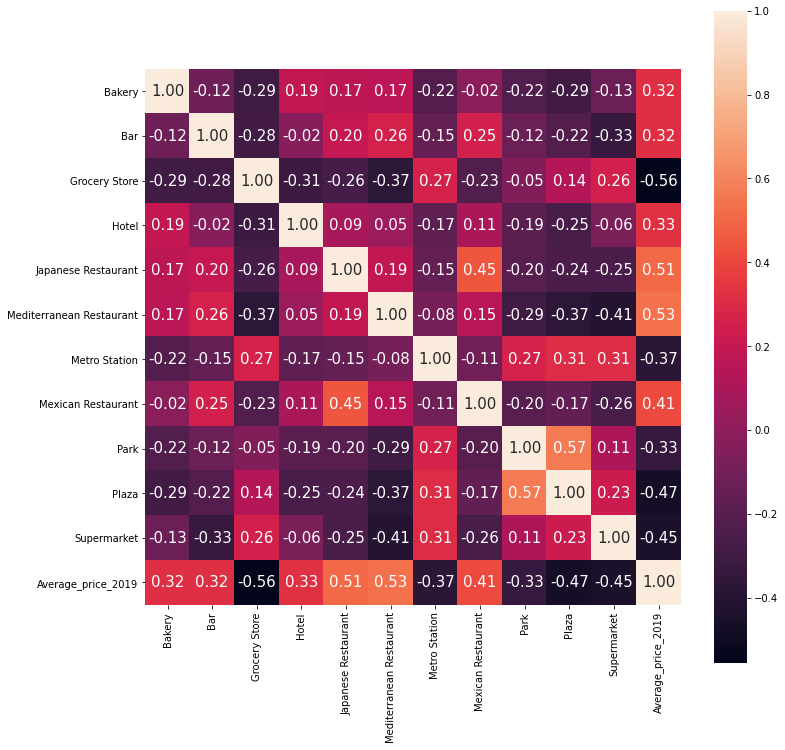

In [ ]:
# We will plot a heatmap of the correlation matrix for the 12 most correlated predictors with the 2019 target
#cols = coef_matrix.iloc[(-np.abs(coef_matrix["Average_price_2019"].values)).argsort()].index[:12]
cols = coef_matrix[useful_features_2019 + ["Average_price_2019"]].columns

coef = np.corrcoef(df_train1[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    coef,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)

In [ ]:
X_train_fs = X_train.loc[:, useful_features_2019]
print(X_train_fs.shape)
print(y_train_2019.shape)

(55, 11)
(55,)


In [ ]:
X_test_fs = X_test.loc[:, useful_features_2019]
print(X_test_fs.shape)
X_test_fs.head()

(14, 11)


,Bakery,Bar,Grocery Store,Hotel,Japanese Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Park,Plaza,Supermarket
46,0.023810,0.000000,0.000000,0.047619,0.095238,0.095238,0.0,0.0,0.000000,0.000000,0.000000
56,0.000000,0.043478,0.173913,0.000000,0.000000,0.000000,0.0,0.0,0.130435,0.043478,0.000000
33,0.069767,0.023256,0.046512,0.046512,0.000000,0.069767,0.0,0.0,0.000000,0.000000,0.046512
36,0.000000,0.000000,0.000000,0.285714,0.000000,0.142857,0.0,0.0,0.285714,0.000000,0.000000
6,0.069767,0.046512,0.023256,0.093023,0.000000,0.069767,0.0,0.0,0.000000,0.000000,0.000000


#### **4.3 Modeling and results**

**4.3.1 Multiple Linear Regression**



2019 prices model:
In-sample r2:  0.6687459694815041
Out of sample r2:  0.5490877037586812
In-sample MSE:  403280.5748899659
Out of sample MSE:  737238.6803263495


2020 prices model:
In-sample r2:  0.6241273471979287
Out of sample r2:  0.5558247331148229
In-sample MSE:  437364.8676034363
Out of sample MSE:  666304.5712196407 




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


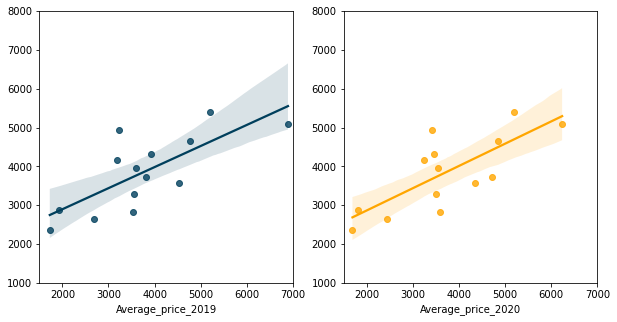

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_fs,y_train_2019)

y1_2019 = model.predict(X_train_fs) #We calculate y1 to test in-sample performance
yhat_2019 = model.predict(X_test_fs)

model2 = LinearRegression()
model2.fit(X_train_fs,y_train_2020)

y1_2020 = model.predict(X_train_fs) #We calculate y1 to test in-sample performance
yhat_2020 = model.predict(X_test_fs)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r_squared_in_2019 = r2_score(y_train_2019, y1_2019)
r_squared_out_2019 = r2_score(y_test_2019, yhat_2019)
mse_in_2019 = mean_squared_error(y_train_2019, y1_2019)
mse_out_2019 = mean_squared_error(y_test_2019, yhat_2019)
print("\n\n2019 prices model:")
print("In-sample r2: ", r_squared_in_2019)
print("Out of sample r2: ", r_squared_out_2019)
print("In-sample MSE: ", mse_in_2019)
print("Out of sample MSE: ", mse_out_2019)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r_squared_in_2020 = r2_score(y_train_2020, y1_2020)
r_squared_out_2020 = r2_score(y_test_2020, yhat_2020)
mse_in_2020 = mean_squared_error(y_train_2020, y1_2020)
mse_out_2020 = mean_squared_error(y_test_2020, yhat_2020)
print("\n\n2020 prices model:")
print("In-sample r2: ", r_squared_in_2020)
print("Out of sample r2: ", r_squared_out_2020)
print("In-sample MSE: ", mse_in_2020)
print("Out of sample MSE: ", mse_out_2020, "\n\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_ylim(1000, 8000)
ax2.set_ylim(1000, 8000)
ax1.set_xlim(1500, 7000)
ax2.set_xlim(1500, 7000)
sns.regplot(y_test_2019, yhat_2019, ax=ax1, color='#003f5c')
sns.regplot(y_test_2020, yhat_2020, ax=ax2, color='#ffa600')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

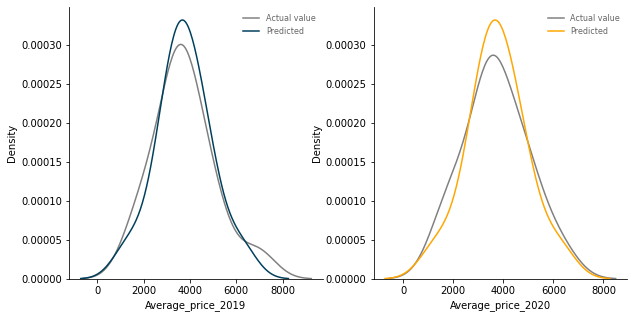

In [ ]:
#We plot a distplot to display out-of-sample accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(y_test_2019, hist=False, color='gray', label='Actual value', ax=ax1)
sns.distplot(yhat_2019, hist=False, color='#003f5c', label='Predicted', ax=ax1)
sns.distplot(y_test_2020, hist=False, color='gray', label='Actual value', ax=ax2)
sns.distplot(yhat_2020, hist=False, color='#ffa600', label='Predicted', ax=ax2)

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#Legend formatting
l1 = ax1.legend(frameon=False, fontsize=8)
for text in l1.get_texts():
    text.set_color("#666666")
l2 = ax2.legend(frameon=False, fontsize=8)
for text in l2.get_texts():
    text.set_color("#666666")

plt.show()

**4.3.2 Random Forest Regression**


In [ ]:
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

**Random Forest with target variable Average price 2019:**

In [ ]:
#First we define the train and test data we will pass to the following function and script
#We will first use the 2019 price data
df_train_X = X_train
df_train_y = y_train_2019
df_test_X = X_test
df_test_y = y_test_2019

In [ ]:
#Define a function fit, plot and print the results of the method ouf our choosing
scores = pd.DataFrame()
def try_method(method):
    method.fit(df_train_X, df_train_y)
    y_pred = method.predict(df_test_X)

    y_test_temp = df_test_y.reset_index(drop=True)
    order = y_pred.argsort(axis=0)
    y_pred = y_pred[order]
    y_test_temp = y_test_temp[order]

    # maer = np.mean(abs(y_pred - y_test_temp) / y_test_temp)
    mse = metrics.mean_squared_error(y_test_temp, y_pred)
    r2 = metrics.r2_score(y_test_temp, y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(len(y_pred)),
        y_test_temp,
        "ro",
        markersize=4,
        label="List price",
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(y_pred)),
        y_pred,
        "bo-",
        markersize=4,
        label="Predicted price",
        alpha=0.9,
    )

    plt.grid()
    plt.title("MSE: %f" % mse)
    print("mean_squared_error: %f" % mse)
    print("r2: %f" % r2)
    #print('mean_abs_error_rate: %f' % maer)
    plt.legend()
    return (r2, mse)

In [ ]:
# parameters to search over with cross-validation
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(df_train_X, df_train_y)

print("Best parameter values: %r\n" % clf.best_params_)

Best parameter values: {'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 100}



mean_squared_error: 819684.642642
r2: 0.498662


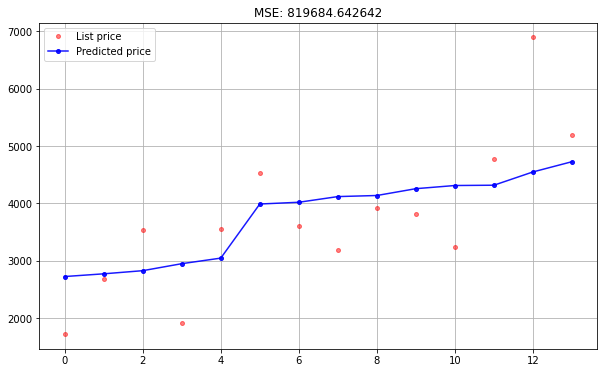

In [ ]:
# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=1234,
)

performance_rf_2019 = try_method(rf)

scores.loc[0, "Random Forest"] = performance_rf_2019[0]
scores.loc[1, "Random Forest"] = performance_rf_2019[1]

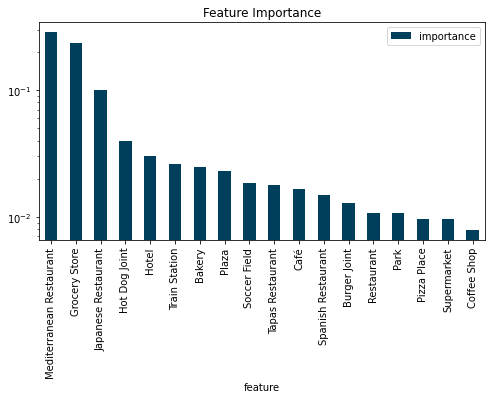

In [ ]:
importance_2019 = pd.DataFrame({"feature": list(df_train_X.columns), "importance": rf.feature_importances_})
importance_2019.sort_values(by="importance", axis=0, ascending=False, inplace=True)
importance_2019[:18].plot(
    x="feature",
    y="importance",
    kind="bar",
    figsize=(8, 4),
    title="Feature Importance",
    logy=True,
    color='#003f5c'
)

**Random Forest with target variable Average price 2020:**

In [ ]:
#First we define the train and test data we will pass to the following function and script
#We will now use the 2020 price data
df_train_X = X_train
df_train_y = y_train_2020
df_test_X = X_test
df_test_y = y_test_2020

In [ ]:
#We will use the model instance we defined before, now with the 2020 data
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(df_train_X, df_train_y)

print("Best parameter values: %r\n" % clf.best_params_)

Best parameter values: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}



mean_squared_error: 713689.178617
r2: 0.524237


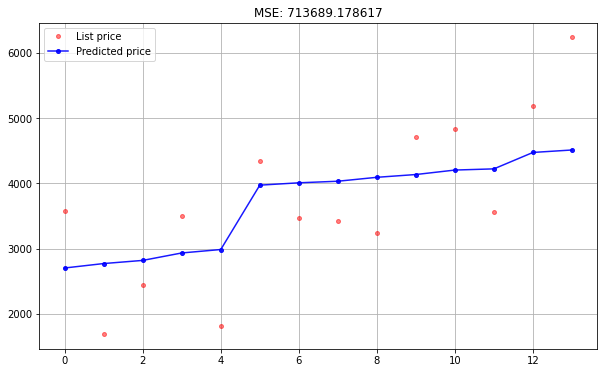

In [ ]:
#Finally we run the function
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=1234,
)

performance_rf_2020 = try_method(rf)

scores.loc[0, "Random Forest"] = performance_rf_2020[0]
scores.loc[1, "Random Forest"] = performance_rf_2020[1]

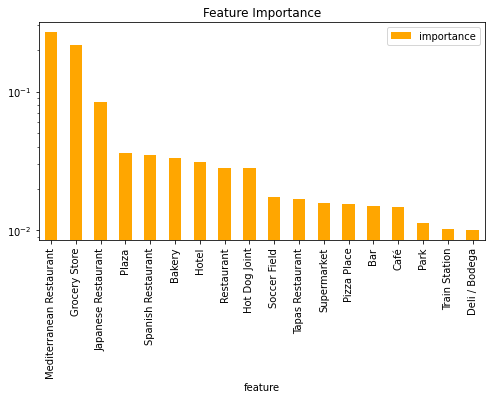

In [ ]:
#Now we look at variable importances
importance_2020 = pd.DataFrame({"feature": list(df_train_X.columns), "importance": rf.feature_importances_})
importance_2020.sort_values(by="importance", axis=0, ascending=False, inplace=True)
importance_2020[:18].plot(
    x="feature",
    y="importance",
    kind="bar",
    figsize=(8, 4),
    title="Feature Importance",
    logy=True,
    color='#ffa600'
)

<a id="id_Results-Discussion"></a>
### **5. Results and discussion**

As seen in the *Modeling and results* section, both Linear Regression and Random Forest models performed very similarly in terms of **r-squared** and **MSE**. The Random Forest, with a larger set of predictor variables (76 in the Random Forest compared to 12 in the Linear Regression) did not display higher out-of-sample accuracy.

&nbsp;

**Linear Regression models:**

2019 prices model:

|  *   | **R2** | **MSE** |
| --- | --- | --- |
|**In-sample** | 0.6687 | 403281 |
|**Out-of-sample** | 0.5491 | 737239 |

&nbsp;

2020 prices model:


|  -   | R2 | MSE |
| --- | --- | --- |
|In-sample | 0.6241 | 437365 |
|Out-of-sample | 0.5558 | 666305 |

&nbsp;

**Random Forest Regression models:**

2019 prices model:

|  *  | **R2** | **MSE** |
| --- | --- | --- |
|**Out-of-sample** | 0.4987 | 819685 |

&nbsp;

2020 prices model:

|  *  | **R2** | **MSE** |
| --- | --- | --- |
|**Out-of-sample** | 0.5195 | 720842 |

&nbsp;

Regarding the comparison between 2019 and 2020(Covid-19) price data, no significant differences were found either in terms of predictor variables or in model accuracy.

The analysis of the correlation plot used to select the features for the Linear Regression model as well as the feature importances that resulted from the Random Forest models display an assortment that suggests that the high cardinality of the variable proves excessive for predicting prices aggregated at neighborhood scale.

The way data transformation and feature engineering was performed leads to models that treat venue categories such as Park, Plaza, Supermarked or Metro Station as negatively correlated with housing price of the neighborhood. At first sight, this association is counterintuitive, since the presence of such types of venues usually makes neighborhoods more appealing and therefore drives housing price upward. Notwithstanding, after analyzing section **3.4 Display top 10 venues for each neighborhood** and comparing the top venues list with the actual neighborhoods, we find that neighborhoods that present Park, Plaza, Supermarket or Metro Station as the most common venue category are those that lack other types of facilities such as bars and restaurants. This is the case of low-income dormitory neighborhoods, where there is a lack of leisure offerings and which usually have lower housing prices.

<a id="id_Conclusion"></a>
### **6. Conclusion**

In conclusion, the results of the study suggest that, although an R2 score of around 0.5 is not to be considered enough in prediction of prices, achieving this rate with the sole use of Foursquare's Venue Category variable to explain housing price variation among neighborhoods proves that data available on social media platforms can improve predictive power of traditional housing valuation models.

In the case of the models developed in this study, an increased number of samples with the availability of more granular pricing data could have improved prediction accuracy. On the other hand, with price data aggregated by neighborhood and low number of observations, a reduction of the number of venue categories by grouping might be advisable to produce a more explainable set of variables with high prediction power in the correlation matrix and feature importance results.

All in all, further studies with data available in the pay-per-use version of the Foursquare API as well as other social media platforms such as Google Places API, Facebook Graph API and Yelp Fusion API could be conducted to improve prediction power and find ways to better complement traditional housing valuation models.

<a id="id_References"></a>
### **7. References**

**1.**	Datos Gob. de España (2019, August 22). *5 examples on how open data can help you find a home*. Retrieved from https://datos.gob.es/en/blog/5-examples-how-open-data-can-help-you-find-home

**2.**	Datos Gob. de España (2019, March 14). *How you could improve the experience of looking for a home with more open data*. Retrieved from https://datos.gob.es/en/blog/how-you-could-improve-experience-looking-home-more-open-data

**3.**	Gourarie, Chava (2020, February 27). *Cadre to Use Foursquare’s Data to Evaluate Investments*. Commercial Observer. Retrieved from https://commercialobserver.com/2020/02/cadre-to-use-foursquares-data-to-evaluate-investments/
